# Assignment 1 — Fish Dataset (Kaggle) — EDA + KFold CNN

Minimal, practical solution using **ImageFolder**.
We create a clean classification directory **once** (images only, no GT), then proceed normally.


In [25]:
%pip -q install kagglehub torch torchvision scikit-learn matplotlib pillow numpy tqdm mlflow



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [26]:
import random
from pathlib import Path
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm.auto import tqdm

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [27]:
import os
import mlflow
import mlflow.pytorch

mlflow.set_tracking_uri(os.environ.get("MLFLOW_TRACKING_URI", "file:./mlruns"))
experiment_name = os.environ.get(
    "MLFLOW_EXPERIMENT_NAME", "fish_kfold_smallcnn")
mlflow.set_experiment(experiment_name)

print("MLflow tracking URI:", mlflow.get_tracking_uri())
print("MLflow experiment:", experiment_name)

MLflow tracking URI: file:./mlruns
MLflow experiment: fish_kfold_smallcnn


## 1) Download dataset


In [28]:
import kagglehub

dataset_root = Path(kagglehub.dataset_download(
    "crowww/a-large-scale-fish-dataset"))
RAW_DIR = dataset_root / "Fish_Dataset" / "Fish_Dataset"
print("RAW_DIR:", RAW_DIR)

RAW_DIR: /Users/danbrima/.cache/kagglehub/datasets/crowww/a-large-scale-fish-dataset/versions/2/Fish_Dataset/Fish_Dataset


## 2) Build a clean ImageFolder directory (images only)
This removes GT folders and keeps standard `ImageFolder` behavior.


In [29]:
import shutil

CLEAN_DIR = Path("fish_classification_clean")  # Changed to a writable location

if not CLEAN_DIR.exists():
    CLEAN_DIR.mkdir()
    for cls_dir in RAW_DIR.iterdir():
        if not cls_dir.is_dir():
            continue
        img_dir = cls_dir / cls_dir.name
        if not img_dir.exists():
            continue
        target = CLEAN_DIR / cls_dir.name
        target.mkdir(exist_ok=True)
        for img in img_dir.iterdir():
            if img.suffix.lower() in (".jpg", ".jpeg", ".png"):
                shutil.copy(img, target / img.name)

print("Clean dataset ready at:", CLEAN_DIR)
print("Classes:", [d.name for d in CLEAN_DIR.iterdir() if d.is_dir()])

Clean dataset ready at: fish_classification_clean
Classes: ['Sea Bass', 'Red Mullet', 'Gilt-Head Bream', 'Red Sea Bream', 'Shrimp', 'Black Sea Sprat', 'Striped Red Mullet', 'Hourse Mackerel', 'Trout']


## 3) EDA


Total images: 9000
Number of classes: 9
['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']


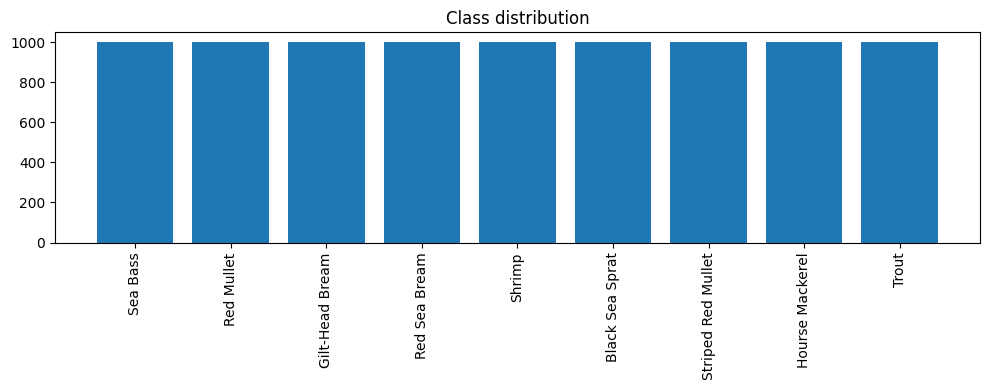

In [30]:
all_images = [p for p in CLEAN_DIR.glob(
    "*/*") if p.suffix.lower() in (".jpg", ".jpeg", ".png")]
classes = sorted([d.name for d in CLEAN_DIR.iterdir() if d.is_dir()])

print("Total images:", len(all_images))
print("Number of classes:", len(classes))
print(classes)

labels = [p.parent.name for p in all_images]
class_counts = Counter(labels)

plt.figure(figsize=(10, 4))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.title("Class distribution")
plt.tight_layout()
plt.show()

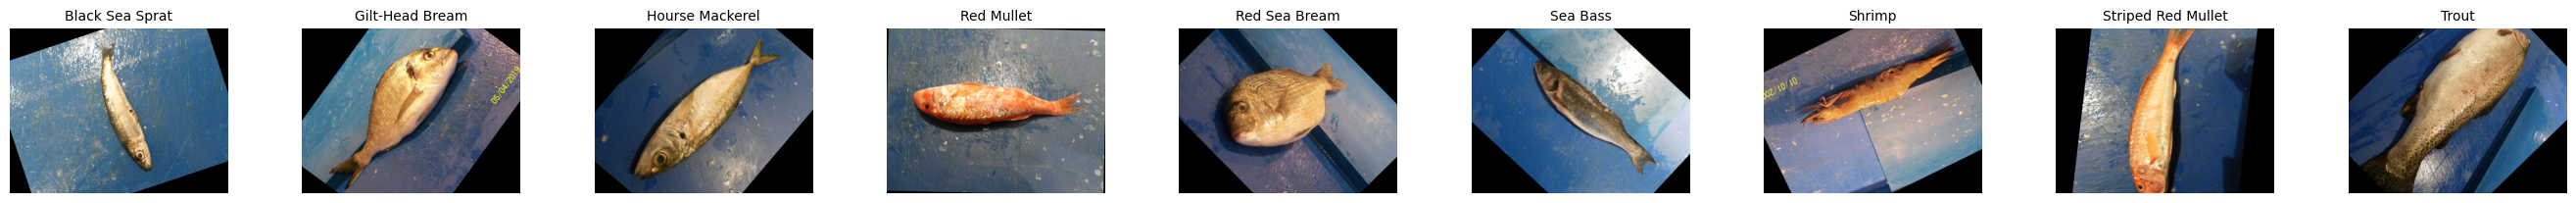

In [31]:
selected_images_paths = []

for class_name in classes:
    class_dir = CLEAN_DIR / class_name
    # Find all image files (case-insensitive for extensions)
    class_images = []
    for ext in ("*.jpg", "*.jpeg", "*.png"):
        class_images.extend(list(class_dir.glob(ext)))

    if class_images:
        selected_images_paths.append(random.choice(class_images))

# Determine grid size for subplots
num_classes = len(selected_images_paths)
rows = 2
cols = num_classes

plt.figure(figsize=(cols * 3, 4))
for i, img_path in enumerate(selected_images_paths):
    plt.subplot(rows, cols, i + 1)
    img = Image.open(img_path)
    class_label = img_path.parent.name
    plt.imshow(img)
    plt.title(class_label, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

## 4) Dataset + transforms


In [32]:
IMG_SIZE = 224

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # Random horizontal flipping is used as a data augmentation technique.
    # For fish species classification, left/right orientation does not change the label,
    # so flipping helps the model learn orientation-invariant features.
    # This increases data diversity, reduces overfitting, and improves generalization.
    transforms.RandomHorizontalFlip(p=0.5),
    # NEW (Suggestion #1): rotation robustness (fix sideways shrimp)
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
])

eval_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

base_ds = ImageFolder(CLEAN_DIR, transform=eval_tf)
num_classes = len(base_ds.classes)
num_classes, base_ds.classes

(9,
 ['Black Sea Sprat',
  'Gilt-Head Bream',
  'Hourse Mackerel',
  'Red Mullet',
  'Red Sea Bream',
  'Sea Bass',
  'Shrimp',
  'Striped Red Mullet',
  'Trout'])

## 5) Model


In [33]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        def block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
            )

        self.features = nn.Sequential(
            block(3, 32),    # -> (N, 32, H/2, W/2)
            block(32, 64),   # -> (N, 64, H/4, W/4)
            block(64, 128),  # -> (N, 128, H/8, W/8)
            nn.AdaptiveAvgPool2d((1, 1)),  # -> (N, 128, 1, 1)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                  # -> (N, 128)
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)    # logits
        )

    def forward(self, x):
        return self.classifier(self.features(x))

## 6) KFold training (K=5)


In [34]:
def run_epoch(model, loader, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    losses, preds, targets = [], [], []

    with torch.set_grad_enabled(is_train):
        for x, y in tqdm(loader, leave=False):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            losses.append(loss.item())
            # store the label predicted (max logit)
            preds.append(logits.argmax(dim=1).detach().cpu().numpy())
            targets.append(y.detach().cpu().numpy())

    preds = np.concatenate(preds)
    targets = np.concatenate(targets)
    return float(np.mean(losses)), accuracy_score(targets, preds), preds, targets

In [35]:
@torch.no_grad()
def predict_proba(model, loader):
    model.eval()
    probs_all, y_all = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        probs_all.append(probs)
        y_all.append(y.numpy())
    return np.vstack(probs_all), np.concatenate(y_all)


@torch.no_grad()
def predict_proba_tta(model, loader, num_classes, use_hflip=True):
    model.eval()

    probs_all = []
    y_all = []

    for x, y in loader:
        x = x.to(device)  # (B, C, H, W)

        # collect probabilities from multiple augmented views
        probs_views = []

        # rotations: 0, 90, 180, 270
        for k in [0, 1, 2, 3]:
            x_rot = torch.rot90(x, k=k, dims=(2, 3))
            logits = model(x_rot)
            probs_views.append(torch.softmax(logits, dim=1))

            if use_hflip:
                # horizontal flip (W dimension)
                x_flip = torch.flip(x_rot, dims=(3,))
                logits_f = model(x_flip)
                probs_views.append(torch.softmax(logits_f, dim=1))

        # average across views -> (B, num_classes)
        probs_mean = torch.stack(probs_views, dim=0).mean(dim=0)

        probs_all.append(probs_mean.cpu().numpy())
        y_all.append(y.numpy())

    return np.vstack(probs_all), np.concatenate(y_all)


def plot_history(hist, title=""):
    plt.figure()
    plt.plot(hist["train_loss"], label="train_loss")
    plt.plot(hist["val_loss"], label="val_loss")
    plt.legend()
    plt.title(title + " loss")
    plt.show()

    plt.figure()
    plt.plot(hist["train_acc"], label="train_acc")
    plt.plot(hist["val_acc"], label="val_acc")
    plt.legend()
    plt.title(title + " accuracy")
    plt.show()

Train pool: 7200 Test: 1800 Classes: 9

===== Fold 1/5 =====


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:03<?, ?it/s]

Epoch 01: train acc=0.669 val acc=0.758


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:03<?, ?it/s]

Epoch 02: train acc=0.869 val acc=0.879


  0%|          | 0/180 [00:03<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 03: train acc=0.931 val acc=0.728


  0%|          | 0/180 [00:03<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 04: train acc=0.955 val acc=0.923


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 05: train acc=0.956 val acc=0.956


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 06: train acc=0.974 val acc=0.947


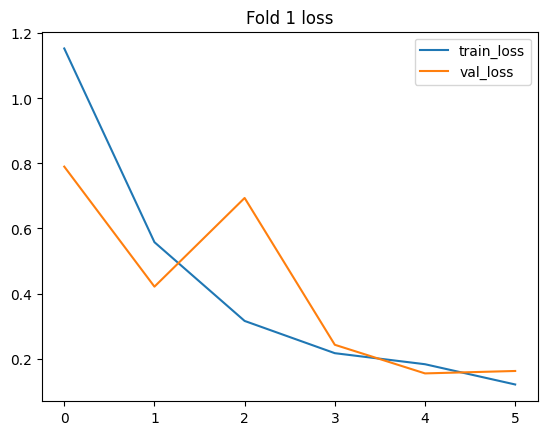

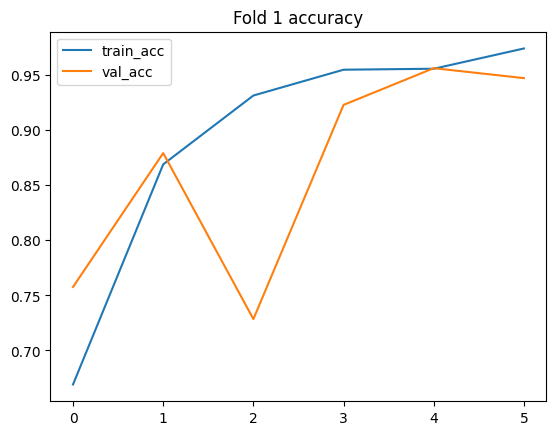

  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

  0%|          | 0/57 [00:02<?, ?it/s]

2025/12/15 13:12:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



===== Fold 2/5 =====


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 01: train acc=0.688 val acc=0.801


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 02: train acc=0.889 val acc=0.816


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 03: train acc=0.936 val acc=0.773


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 04: train acc=0.959 val acc=0.949


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 05: train acc=0.975 val acc=0.984


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 06: train acc=0.980 val acc=0.862


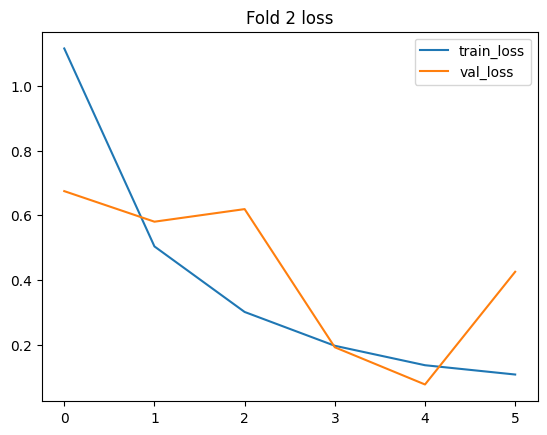

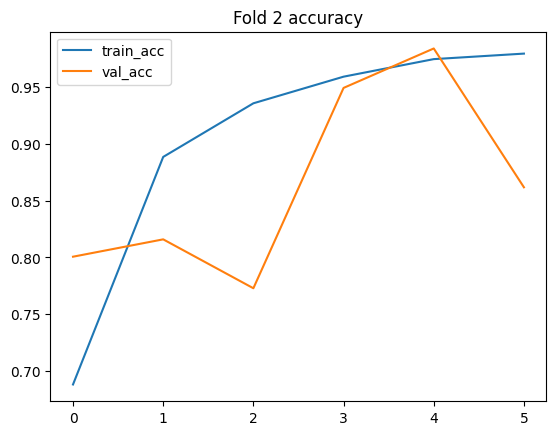

  0%|          | 0/180 [00:01<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

  0%|          | 0/57 [00:01<?, ?it/s]

2025/12/15 14:48:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



===== Fold 3/5 =====


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 01: train acc=0.658 val acc=0.748


  0%|          | 0/180 [00:01<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 02: train acc=0.868 val acc=0.795


  0%|          | 0/180 [00:01<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 03: train acc=0.939 val acc=0.396


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 04: train acc=0.963 val acc=0.986


  0%|          | 0/180 [00:01<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 05: train acc=0.978 val acc=0.644


  0%|          | 0/180 [00:01<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 06: train acc=0.980 val acc=0.886


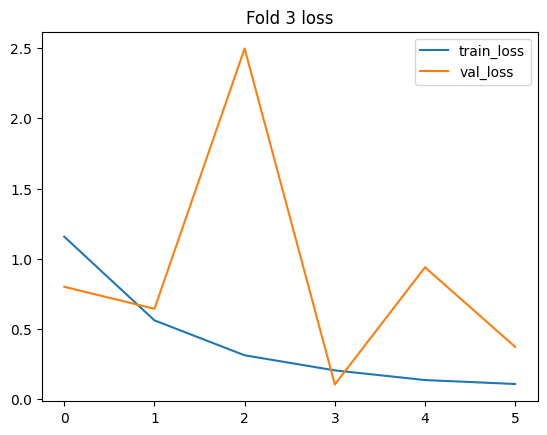

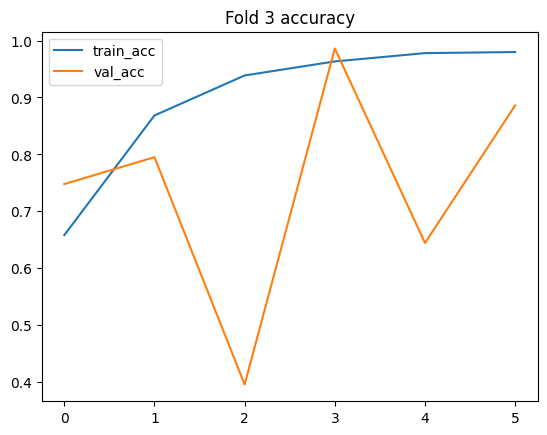

  0%|          | 0/180 [00:01<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

  0%|          | 0/57 [00:02<?, ?it/s]

2025/12/15 16:06:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



===== Fold 4/5 =====


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 01: train acc=0.681 val acc=0.847


  0%|          | 0/180 [00:01<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 02: train acc=0.867 val acc=0.833


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 03: train acc=0.915 val acc=0.884


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 04: train acc=0.946 val acc=0.848


  0%|          | 0/180 [00:01<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 05: train acc=0.962 val acc=0.936


  0%|          | 0/180 [00:01<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 06: train acc=0.972 val acc=0.960


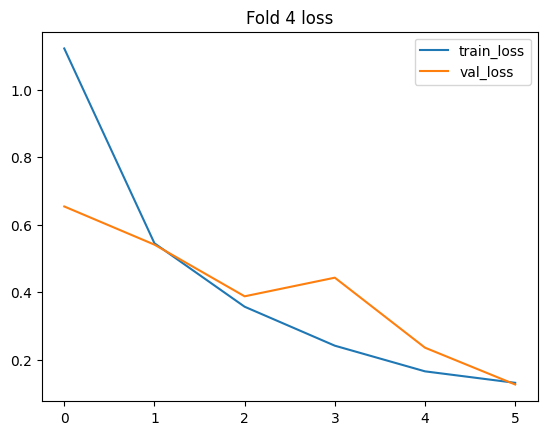

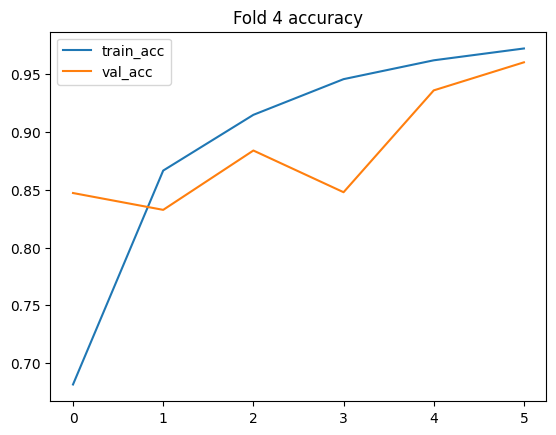

  0%|          | 0/180 [00:01<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

  0%|          | 0/57 [00:02<?, ?it/s]

2025/12/15 17:25:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



===== Fold 5/5 =====


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 01: train acc=0.694 val acc=0.842


  0%|          | 0/180 [00:01<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 02: train acc=0.879 val acc=0.938


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 03: train acc=0.923 val acc=0.886


  0%|          | 0/180 [00:01<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 04: train acc=0.948 val acc=0.837


  0%|          | 0/180 [00:01<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 05: train acc=0.962 val acc=0.956


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 06: train acc=0.971 val acc=0.957


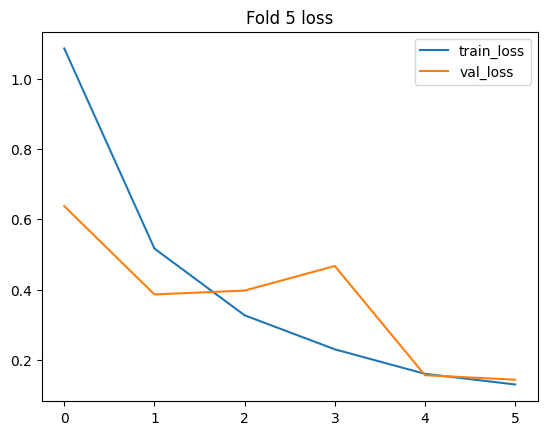

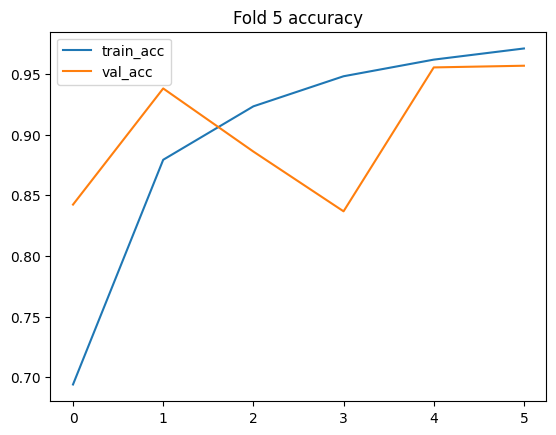

  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

  0%|          | 0/57 [00:02<?, ?it/s]

2025/12/15 18:45:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


fold  train_loss  train_acc  val_loss   val_acc  test_loss  test_acc
0     1    0.157055   0.948785  0.161940  0.947222   0.153672  0.951667
1     2    0.402131   0.867361  0.425775  0.861806   0.380953  0.872778
2     3    0.369979   0.881076  0.372483  0.886111   0.367810  0.882222
3     4    0.117883   0.966840  0.126551  0.960417   0.115761  0.971667
4     5    0.135193   0.962847  0.143557  0.956944   0.142367  0.954444


=== Mean-of-folds ensemble (TEST) ===
Ensemble test loss: 0.1522131860256195
Ensemble test acc : 0.9966666666666667


fold  train_loss  train_acc  val_loss   val_acc  test_loss  test_acc  \
0     1    0.157055   0.948785  0.161940  0.947222   0.153672  0.951667   
1     2    0.402131   0.867361  0.425775  0.861806   0.380953  0.872778   
2     3    0.369979   0.881076  0.372483  0.886111   0.367810  0.882222   
3     4    0.117883   0.966840  0.126551  0.960417   0.115761  0.971667   
4     5    0.135193   0.962847  0.143557  0.956944   0.142367  0.954444   

   ensemble_test_acc  
0           0.996667  
1           0.996667  
2           0.996667  
3           0.996667  
4           0.996667

In [36]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
import pandas as pd
import time

# --- Settings ---
K = 5
epochs = 6
batch_size = 32
lr = 1e-3

# --- Build a fixed TEST split (so "test" is real) ---
base_eval_ds = ImageFolder(CLEAN_DIR, transform=eval_tf)
y_all = np.array([y for _, y in base_eval_ds.samples])
idx_all = np.arange(len(y_all))

sss = StratifiedShuffleSplit(
    n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
train_pool_idx, test_idx = next(sss.split(idx_all, y_all))
y_train_pool = y_all[train_pool_idx]

test_ds = ImageFolder(CLEAN_DIR, transform=eval_tf)
test_loader = DataLoader(
    Subset(test_ds, test_idx),
    batch_size=batch_size, shuffle=False, num_workers=2
)

print("Train pool:", len(train_pool_idx), "Test:", len(
    test_idx), "Classes:", len(base_eval_ds.classes))

# --- KFold on the training pool ---
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=RANDOM_SEED)

fold_rows = []
fold_test_probs = []  # for mean-of-folds ensemble on TEST
test_targets = None

for fold, (tr_rel, va_rel) in enumerate(skf.split(np.zeros(len(train_pool_idx)), y_train_pool), start=1):
    print(f"\n===== Fold {fold}/{K} =====")

    tr_idx = train_pool_idx[tr_rel]
    va_idx = train_pool_idx[va_rel]

    # Train dataset uses augmentation; eval datasets do not
    train_ds = ImageFolder(CLEAN_DIR, transform=train_tf)
    train_eval_ds = ImageFolder(CLEAN_DIR, transform=eval_tf)
    val_ds = ImageFolder(CLEAN_DIR, transform=eval_tf)

    train_loader = DataLoader(Subset(train_ds, tr_idx),
                              batch_size=batch_size, shuffle=True, num_workers=2)
    train_eval_loader = DataLoader(Subset(train_eval_ds, tr_idx),
                                   batch_size=batch_size, shuffle=False, num_workers=2)
    val_loader = DataLoader(Subset(val_ds, va_idx),
                            batch_size=batch_size, shuffle=False, num_workers=2)

    model = SmallCNN(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    hist = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    run_name = f"fold_{fold}"
    start_time = time.time()

    with mlflow.start_run(run_name=run_name):
        mlflow.log_params({
            "dataset": "fish_classification_clean (ImageFolder)",
            "clean_dir": str(CLEAN_DIR),
            "model": "SmallCNN2",
            "num_classes": int(num_classes),
            "img_size": int(IMG_SIZE),
            "k_folds": int(K),
            "epochs": int(epochs),
            "batch_size": int(batch_size),
            "lr": float(lr),
            "seed": int(RANDOM_SEED),
            "fold": int(fold),
        })

        for ep in range(1, epochs + 1):
            tr_loss, tr_acc, _, _ = run_epoch(
                model, train_loader, criterion, optimizer)
            va_loss, va_acc, _, _ = run_epoch(model, val_loader, criterion)

            hist["train_loss"].append(tr_loss)
            hist["train_acc"].append(tr_acc)
            hist["val_loss"].append(va_loss)
            hist["val_acc"].append(va_acc)

            print(
                f"Epoch {ep:02d}: train acc={tr_acc:.3f} val acc={va_acc:.3f}")

            mlflow.log_metrics({
                "train_loss": float(tr_loss),
                "train_acc": float(tr_acc),
                "val_loss": float(va_loss),
                "val_acc": float(va_acc),
            }, step=ep)

        # Show learning curves (still displayed in the notebook)
        plot_history(hist, title=f"Fold {fold}")

        # Final metrics: train (clean eval), val, test
        train_loss, train_acc, _, _ = run_epoch(
            model, train_eval_loader, criterion)
        val_loss, val_acc, _, _ = run_epoch(model, val_loader, criterion)
        test_loss, test_acc, _, _ = run_epoch(model, test_loader, criterion)

        mlflow.log_metrics({
            "final_train_loss": float(train_loss),
            "final_train_acc": float(train_acc),
            "final_val_loss": float(val_loss),
            "final_val_acc": float(val_acc),
            "test_loss": float(test_loss),
            "test_acc": float(test_acc),
            "runtime_sec": float(time.time() - start_time),
        })

        # Store test probabilities for ensemble
        probs, test_targets = predict_proba(model, test_loader)
        fold_test_probs.append(probs)

        # Log the model (optional but useful)
        mlflow.pytorch.log_model(model, artifact_path="model")

        fold_rows.append({
            "fold": fold,
            "train_loss": float(train_loss),
            "train_acc": float(train_acc),
            "val_loss": float(val_loss),
            "val_acc": float(val_acc),
            "test_loss": float(test_loss),
            "test_acc": float(test_acc),
        })

df_folds = pd.DataFrame(fold_rows)
display(df_folds)

# --- Mean-of-folds ensemble on TEST ---
mean_probs = np.mean(np.stack(fold_test_probs, axis=0), axis=0)
mean_pred = mean_probs.argmax(axis=1)

ensemble_test_acc = float(accuracy_score(test_targets, mean_pred))
eps = 1e-12
ensemble_test_loss = float(
    np.mean(-np.log(mean_probs[np.arange(len(test_targets)), test_targets] + eps)))

print("\n=== Mean-of-folds ensemble (TEST) ===")
print("Ensemble test loss:", ensemble_test_loss)
print("Ensemble test acc :", ensemble_test_acc)

# Log ensemble summary in its own MLflow run
with mlflow.start_run(run_name="ensemble_mean_of_folds"):
    mlflow.log_params({
        "dataset": "fish_classification_clean (ImageFolder)",
        "clean_dir": str(CLEAN_DIR),
        "model_family": "SmallCNN (per-fold) -> mean-prob ensemble",
        "num_classes": int(num_classes),
        "img_size": int(IMG_SIZE),
        "k_folds": int(K),
        "epochs": int(epochs),
        "batch_size": int(batch_size),
        "lr": float(lr),
        "seed": int(RANDOM_SEED),
    })
    mlflow.log_metrics({
        "ensemble_test_loss": float(ensemble_test_loss),
        "ensemble_test_acc": float(ensemble_test_acc),
    })
    mlflow.log_text(df_folds.to_csv(index=False), "fold_metrics.csv")

# Compare per-fold test acc vs ensemble acc
df_compare = df_folds.copy()
df_compare["ensemble_test_acc"] = ensemble_test_acc
display(df_compare)

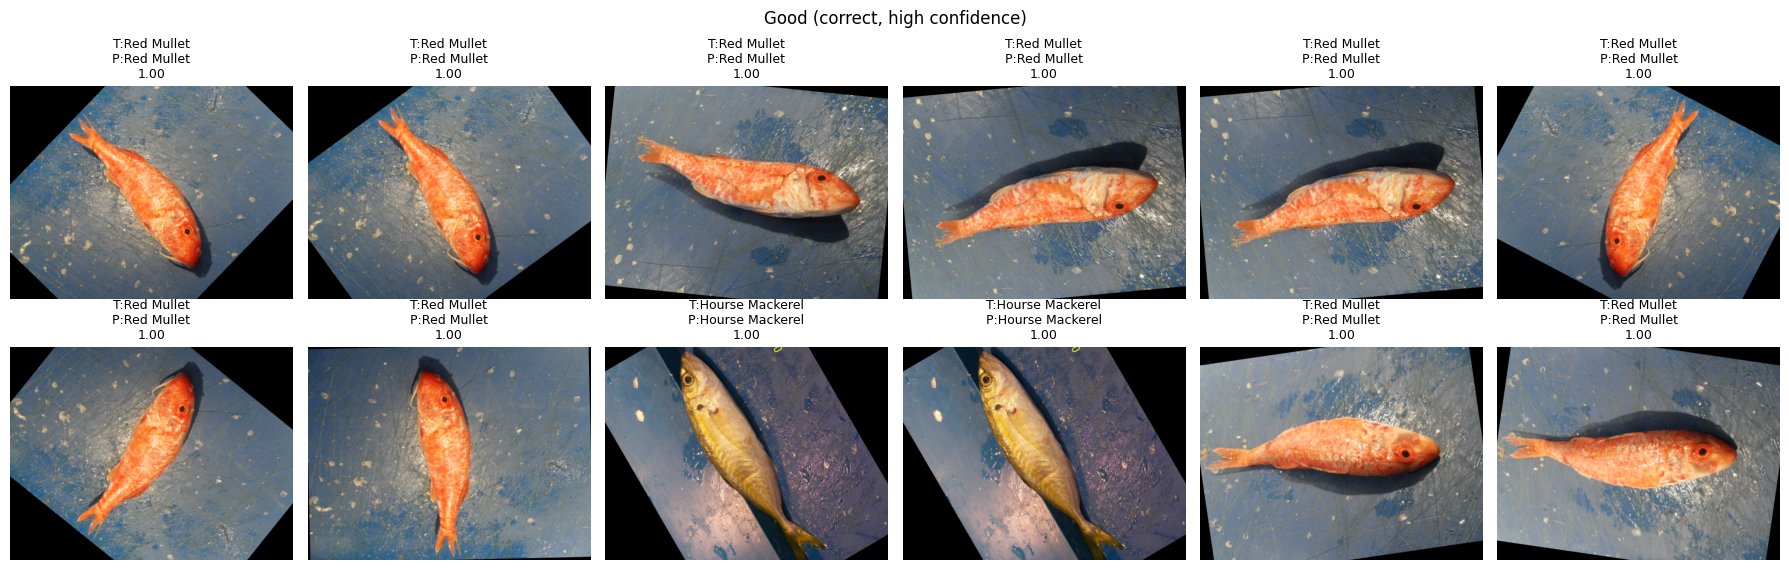

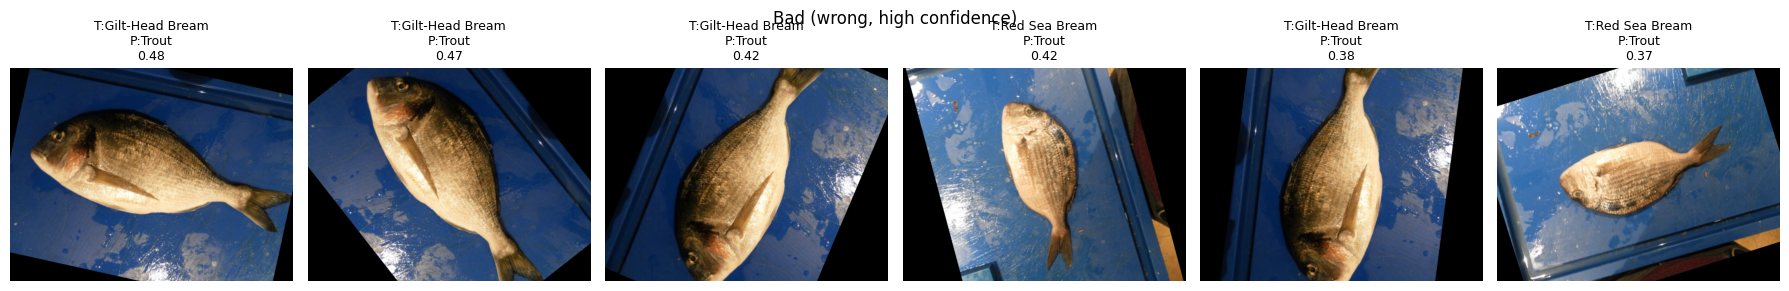

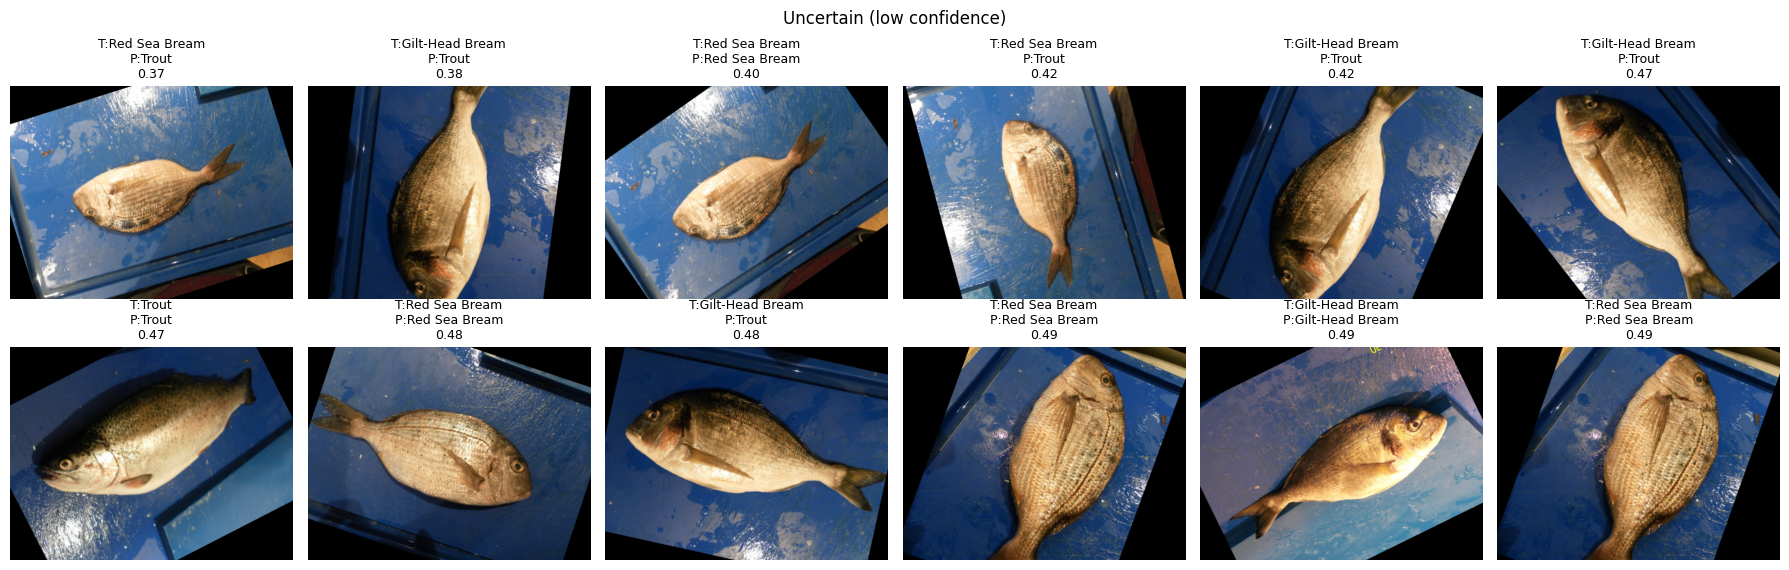

In [37]:
def show_examples(title, chosen_indices, subset_indices, probs, y_true, class_names, max_cols=6):
    cols = min(max_cols, len(chosen_indices))
    rows = int(np.ceil(len(chosen_indices) / cols))
    plt.figure(figsize=(cols * 3, rows * 3))
    plt.suptitle(title)

    for j, i in enumerate(chosen_indices):
        global_idx = subset_indices[i]
        img_path, yt = base_eval_ds.samples[global_idx]
        img = Image.open(img_path).convert("RGB")

        yp = int(probs[i].argmax())
        conf = float(probs[i].max())

        ax = plt.subplot(rows, cols, j + 1)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(
            f"T:{class_names[yt]}\nP:{class_names[yp]}\n{conf:.2f}", fontsize=9)

    plt.tight_layout()
    plt.show()


# Build y_true for test subset in same order as mean_probs
test_subset_indices = test_idx
y_true_test = np.array([base_eval_ds.samples[i][1]
                       for i in test_subset_indices])
class_names = base_eval_ds.classes

y_pred = mean_probs.argmax(axis=1)
conf = mean_probs.max(axis=1)

correct = np.where(y_pred == y_true_test)[0]
wrong = np.where(y_pred != y_true_test)[0]
uncertain = np.argsort(conf)[:12]  # lowest confidence

good_sorted = correct[np.argsort(-conf[correct])]
bad_sorted = wrong[np.argsort(-conf[wrong])]

show_examples("Good (correct, high confidence)",
              good_sorted[:12], test_subset_indices, mean_probs, y_true_test, class_names)
show_examples("Bad (wrong, high confidence)",
              bad_sorted[:12], test_subset_indices, mean_probs, y_true_test, class_names)
show_examples("Uncertain (low confidence)",
              uncertain[:12], test_subset_indices, mean_probs, y_true_test, class_names)

The model misclassifies shrimps that are horizontal,
we have 3 suggestes:
1.	Add rotation augmentation (most important here)
Teach the model that “shrimp sideways is still shrimp”.
	2.	Normalize inputs + stabilize conv blocks (BatchNorm)
Normalization helps optimization; BatchNorm improves training stability and often generalization.
  3.	Increase model capacity (more filters / deeper)

In [48]:
from PIL import Image
import torch

img_path = "shrimp.jpg"

# 1) Load image
img = Image.open(img_path).convert("RGB")

# 2) Use the SAME eval transform you trained/evaluated with
x = eval_tf(img).unsqueeze(0).to(device)   # (1, 3, 224, 224)

# 3) Predict with your trained SmallCNN
model.eval()
with torch.no_grad():
    logits = model(x)                      # (1, num_classes)
    probs = torch.softmax(logits, dim=1)[0]

class_names = base_ds.classes              # ImageFolder class order

# 4) Top-k results
k = min(5, len(class_names))
top_p, top_i = torch.topk(probs, k)

print(f"Image: {img_path}")
for p, i in zip(top_p.cpu().tolist(), top_i.cpu().tolist()):
    print(f"{class_names[i]:<20} prob={p:.4f}")

pred_idx = int(torch.argmax(probs).item())
print("\nPredicted class:", class_names[pred_idx])

Image: shrimp.jpg
Shrimp               prob=0.5793
Sea Bass             prob=0.0924
Red Sea Bream        prob=0.0715
Trout                prob=0.0697
Gilt-Head Bream      prob=0.0552

Predicted class: Shrimp


# Part 3 — Transfer Learning with 4 pretrained architectures (torchvision)
We will fine-tune 4 pretrained models, compare validation/test metrics, compute “unique correct / unique errors” on the test set,
then train a classical ML classifier on deep features from the best model.

In [39]:
import time
import pandas as pd
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.models as models

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [40]:
RANDOM_SEED = 42  # keep same
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Build a fixed TEST split (20%)
base_eval_ds = ImageFolder(CLEAN_DIR, transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
]))
y_all = np.array([y for _, y in base_eval_ds.samples])
idx_all = np.arange(len(y_all))

sss_test = StratifiedShuffleSplit(
    n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
train_pool_idx, test_idx = next(sss_test.split(idx_all, y_all))

# Build a fixed VAL split inside the train_pool (20% of train_pool)
y_train_pool = y_all[train_pool_idx]
sss_val = StratifiedShuffleSplit(
    n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
tr_rel, va_rel = next(sss_val.split(
    np.zeros(len(train_pool_idx)), y_train_pool))
train_idx = train_pool_idx[tr_rel]
val_idx = train_pool_idx[va_rel]

print("Train:", len(train_idx), "Val:", len(val_idx), "Test:",
      len(test_idx), "Classes:", len(base_eval_ds.classes))
num_classes = len(base_eval_ds.classes)
class_names = base_eval_ds.classes

Train: 5760 Val: 1440 Test: 1800 Classes: 9


In [41]:
def build_tforms_from_weights(weights, train_aug=True):
    # Official preprocessing for this pretrained weights object
    base_preprocess = weights.transforms()

    if not train_aug:
        return base_preprocess

    # Add label-preserving augmentations BEFORE the pretrained preprocessing.
    # (These operate on PIL images; base_preprocess will handle resize/tensor/normalize.)
    return transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=30),
        base_preprocess,
    ])

In [42]:
def make_loaders(train_transform, eval_transform, batch_size=32, num_workers=2):
    train_ds = ImageFolder(CLEAN_DIR, transform=train_transform)
    val_ds = ImageFolder(CLEAN_DIR, transform=eval_transform)
    test_ds = ImageFolder(CLEAN_DIR, transform=eval_transform)

    train_loader = DataLoader(Subset(
        train_ds, train_idx), batch_size=batch_size, shuffle=True,  num_workers=num_workers)
    val_loader = DataLoader(Subset(
        val_ds,   val_idx),   batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(Subset(
        test_ds,  test_idx),  batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader

In [43]:
def make_pretrained_model(model_name, num_classes):
    if model_name == "resnet18":
        weights = models.ResNet18_Weights.DEFAULT
        model = models.resnet18(weights=weights)
        in_f = model.fc.in_features
        model.fc = nn.Linear(in_f, num_classes)
        return model, weights

    if model_name == "efficientnet_b0":
        weights = models.EfficientNet_B0_Weights.DEFAULT
        model = models.efficientnet_b0(weights=weights)
        in_f = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_f, num_classes)
        return model, weights

    if model_name == "vgg16_bn":
        weights = models.VGG16_BN_Weights.DEFAULT
        model = models.vgg16_bn(weights=weights)
        in_f = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_f, num_classes)
        return model, weights

    if model_name == "densenet121":
        weights = models.DenseNet121_Weights.DEFAULT
        model = models.densenet121(weights=weights)
        in_f = model.classifier.in_features
        model.classifier = nn.Linear(in_f, num_classes)
        return model, weights

    raise ValueError(f"Unknown model_name: {model_name}")


def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

In [44]:
def finetune_and_eval(model, train_loader, val_loader, test_loader, epochs=2, lr=1e-4, weight_decay=1e-4):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=lr, weight_decay=weight_decay)

    hist = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    t0 = time.perf_counter()
    for ep in range(1, epochs + 1):
        tr_loss, tr_acc, _, _ = run_epoch(
            model, train_loader, criterion, optimizer)
        va_loss, va_acc, _, _ = run_epoch(model, val_loader, criterion)

        hist["train_loss"].append(tr_loss)
        hist["train_acc"].append(tr_acc)
        hist["val_loss"].append(va_loss)
        hist["val_acc"].append(va_acc)

        print(f"Epoch {ep:02d}: train acc={tr_acc:.3f} val acc={va_acc:.3f}")
    runtime_sec = time.perf_counter() - t0

    # Final eval on val + test (also keep test preds for uniqueness)
    val_loss, val_acc, _, _ = run_epoch(model, val_loader, criterion)
    test_loss, test_acc, test_pred, test_true = run_epoch(
        model, test_loader, criterion)

    return {
        "model": model,
        "hist": hist,
        "runtime_sec": runtime_sec,
        "val_loss": float(val_loss),
        "val_acc": float(val_acc),
        "test_loss": float(test_loss),
        "test_acc": float(test_acc),
        "test_pred": test_pred,
        "test_true": test_true,
    }


Training: resnet18


ResNet18_Weights.IMAGENET1K_V1


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 01: train acc=0.955 val acc=0.997


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 02: train acc=0.999 val acc=0.998


  0%|          | 0/45 [00:02<?, ?it/s]

  0%|          | 0/57 [00:02<?, ?it/s]

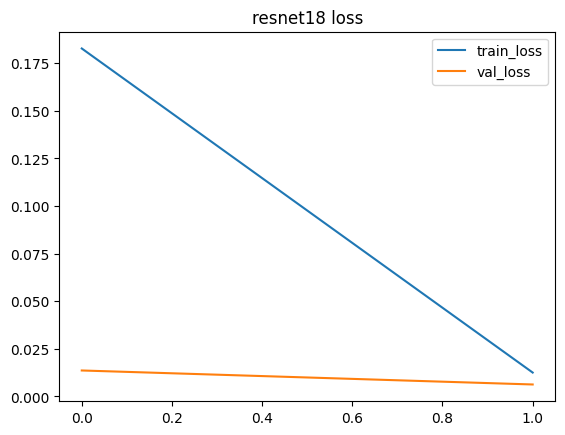

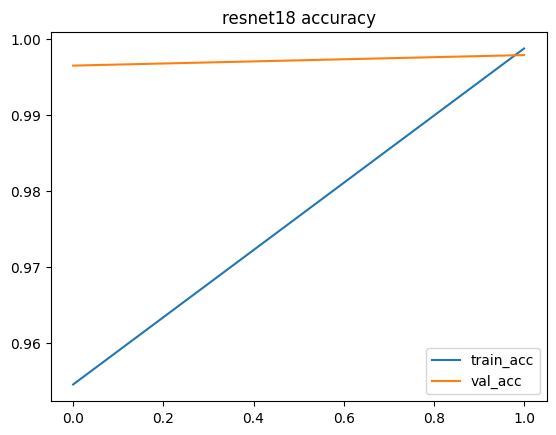


Training: efficientnet_b0
EfficientNet_B0_Weights.IMAGENET1K_V1


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 01: train acc=0.915 val acc=1.000


  0%|          | 0/180 [00:01<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 02: train acc=0.998 val acc=1.000


  0%|          | 0/45 [00:02<?, ?it/s]

  0%|          | 0/57 [00:02<?, ?it/s]

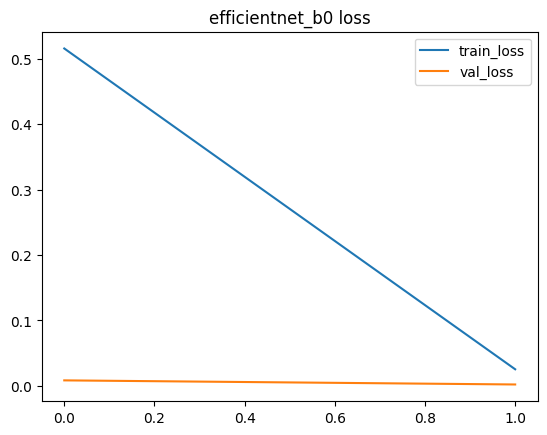

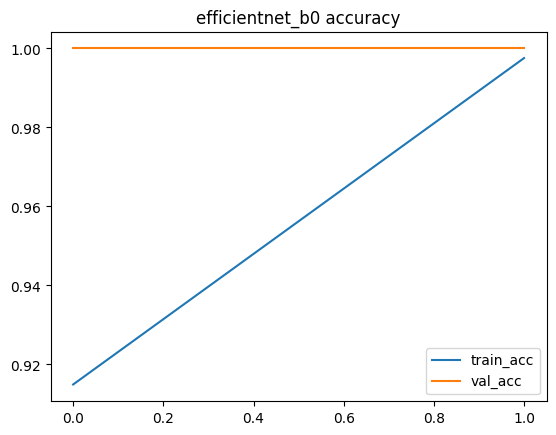


Training: vgg16_bn
VGG16_BN_Weights.IMAGENET1K_V1


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 01: train acc=0.947 val acc=0.999


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 02: train acc=0.993 val acc=0.996


  0%|          | 0/45 [00:01<?, ?it/s]

  0%|          | 0/57 [00:02<?, ?it/s]

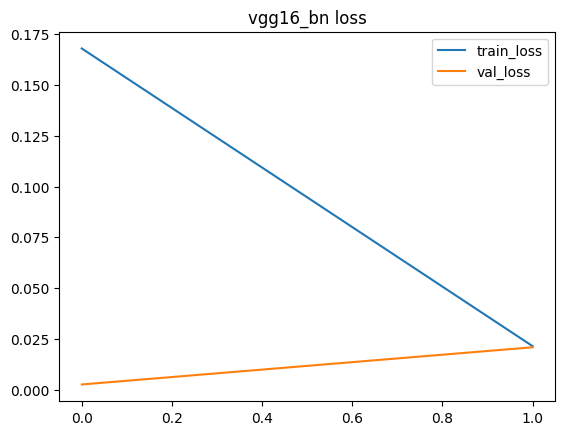

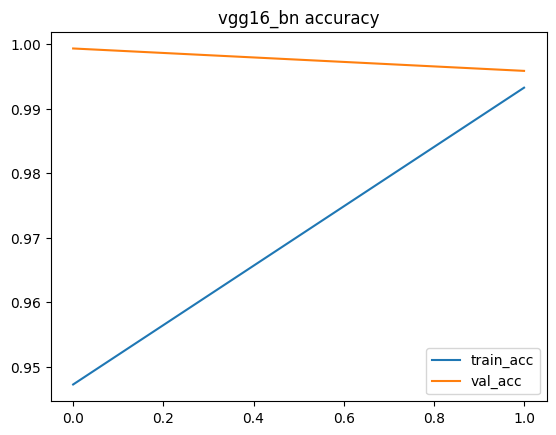


Training: densenet121
DenseNet121_Weights.IMAGENET1K_V1


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 01: train acc=0.961 val acc=1.000


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 02: train acc=0.999 val acc=1.000


  0%|          | 0/45 [00:01<?, ?it/s]

  0%|          | 0/57 [00:01<?, ?it/s]

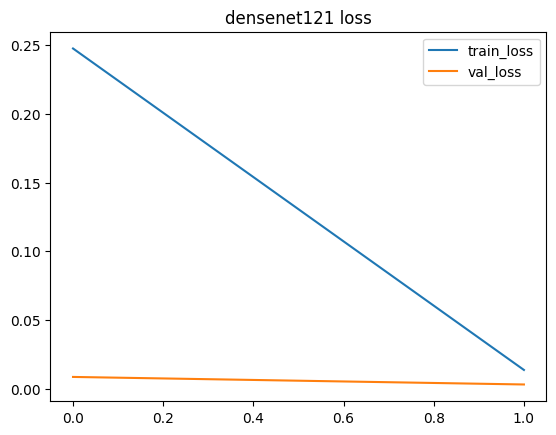

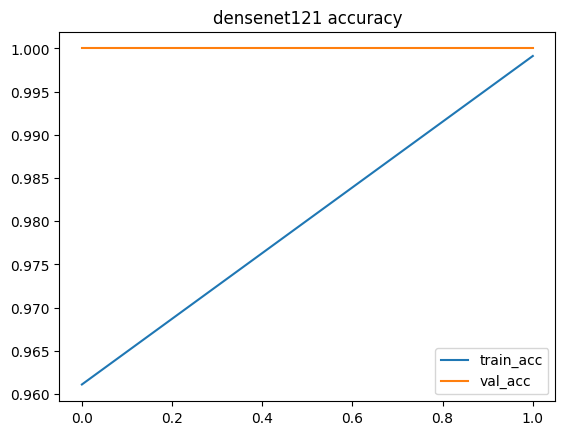

Model Name  # parameters  Validation Loss  Validation Accuracy  \
0         resnet18      11181129         0.006310             0.997917   
1  efficientnet_b0       4019077         0.001866             1.000000   
2         vgg16_bn     134305865         0.020845             0.995833   
3      densenet121       6963081         0.003212             1.000000   

   Test Loss  Test Accuracy  runtime_sec  
0   0.005060       0.999444   978.603985  
1   0.001911       1.000000  3720.045626  
2   0.011494       0.996111  5812.229021  
3   0.003412       1.000000  3395.276052

In [45]:
MODEL_NAMES = ["resnet18", "efficientnet_b0", "vgg16_bn", "densenet121"]

rows = []
test_correct_matrix = {}   # name -> boolean array on test set
# name -> trained model object (for feature extractor step)
trained_models = {}

for name in MODEL_NAMES:
    print("\n==============================")
    print("Training:", name)

    model, weights = make_pretrained_model(name, num_classes)
    total_p, trainable_p = count_params(model)

    print(weights)
    train_tf_m = build_tforms_from_weights(weights, train_aug=True)
    eval_tf_m = build_tforms_from_weights(weights, train_aug=False)
    train_loader, val_loader, test_loader = make_loaders(
        train_tf_m, eval_tf_m, batch_size=32, num_workers=2)

    out = finetune_and_eval(model, train_loader, val_loader,
                            test_loader, epochs=2, lr=1e-4, weight_decay=1e-4)

    # learning curves (optional but usually useful for report)
    plot_history(out["hist"], title=name)

    y_true = out["test_true"]
    y_pred = out["test_pred"]
    correct = (y_pred == y_true)
    test_correct_matrix[name] = correct
    trained_models[name] = out["model"]

    rows.append({
        "Model Name": name,
        "# parameters": total_p,
        "Validation Loss": out["val_loss"],
        "Validation Accuracy": out["val_acc"],
        "Test Loss": out["test_loss"],
        "Test Accuracy": out["test_acc"],
        "runtime_sec": out["runtime_sec"],
    })

df_models = pd.DataFrame(rows)
display(df_models)

In [46]:
names = MODEL_NAMES
C = np.stack([test_correct_matrix[n] for n in names], axis=0)  # (M, Ntest)

unique_correct = {}
unique_errors = {}

for i, name in enumerate(names):
    this = C[i]
    others = np.delete(C, i, axis=0)

    unique_correct[name] = int(np.sum(this & (~others.any(axis=0))))
    unique_errors[name] = int(np.sum((~this) & (others.all(axis=0))))

df_models["# unique correct samples"] = df_models["Model Name"].map(
    unique_correct)
df_models["# unique errors"] = df_models["Model Name"].map(unique_errors)

display(df_models)

Model Name  # parameters  Validation Loss  Validation Accuracy  \
0         resnet18      11181129         0.006310             0.997917   
1  efficientnet_b0       4019077         0.001866             1.000000   
2         vgg16_bn     134305865         0.020845             0.995833   
3      densenet121       6963081         0.003212             1.000000   

   Test Loss  Test Accuracy  runtime_sec  # unique correct samples  \
0   0.005060       0.999444   978.603985                         0   
1   0.001911       1.000000  3720.045626                         0   
2   0.011494       0.996111  5812.229021                         0   
3   0.003412       1.000000  3395.276052                         0   

   # unique errors  
0                1  
1                0  
2                7  
3                0

In [47]:
# --- Feature extraction using ONLY ResNet18 (create_feature_extractor option) ---
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision.models as models

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1) Use the already fine-tuned ResNet from your training loop (cell 28)
resnet = trained_models["resnet18"]

# 2) Build the correct eval preprocessing for ResNet18 weights
resnet_weights = models.ResNet18_Weights.DEFAULT
eval_tf_resnet = build_tforms_from_weights(resnet_weights, train_aug=False)

# 3) Build datasets/loaders for embeddings extraction (train_pool vs test split)
trainpool_ds = ImageFolder(CLEAN_DIR, transform=eval_tf_resnet)
test_ds_feat = ImageFolder(CLEAN_DIR, transform=eval_tf_resnet)

trainpool_loader = DataLoader(
    Subset(trainpool_ds, train_pool_idx),
    batch_size=64, shuffle=False, num_workers=2
)
test_loader_feat = DataLoader(
    Subset(test_ds_feat, test_idx),
    batch_size=64, shuffle=False, num_workers=2
)

# 4) Create a feature extractor that returns the avgpool output (before the final fc)
feat_model = create_feature_extractor(
    resnet, return_nodes={"avgpool": "feat"}).to(device).eval()


@torch.no_grad()
def extract_features(model, loader):
    feats, ys = [], []
    for x, y in loader:
        x = x.to(device)
        out = model(x)["feat"]          # (B, C, 1, 1)
        out = torch.flatten(out, 1)     # (B, C)
        feats.append(out.cpu().numpy())
        ys.append(y.numpy())
    return np.vstack(feats), np.concatenate(ys)


# 5) Extract embeddings
X_train, y_train = extract_features(feat_model, trainpool_loader)
X_test,  y_test = extract_features(feat_model, test_loader_feat)

print("Embedding shapes:", X_train.shape, X_test.shape)

# 6) Classical ML on embeddings
clf = LogisticRegression(max_iter=3000, n_jobs=-1,
                         solver="lbfgs", multi_class="multinomial")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

emb_acc = float(accuracy_score(y_test, y_pred))
print("LogReg-on-ResNet-embeddings test acc:", emb_acc)

# 7) Compare to end-to-end ResNet classifier accuracy (uses your existing test_loader + criterion)
_, resnet_test_acc, _, _ = run_epoch(resnet, test_loader, criterion)
print("End-to-end ResNet test acc:", float(resnet_test_acc))
print("Delta (Embeddings+LR - ResNet):", emb_acc - float(resnet_test_acc))

Embedding shapes: (7200, 512) (1800, 512)


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogReg-on-ResNet-embeddings test acc: 1.0


  0%|          | 0/57 [00:02<?, ?it/s]

End-to-end ResNet test acc: 0.9994444444444445
Delta (Embeddings+LR - ResNet): 0.0005555555555555314
